## Analyzing Sentiments and Geopolitical Stances in Reddit Comments on Israel-Palestine Conflict

## **Introduction:**

In this notebook, I aim to compare and contrast sentiment found in reddit commens related to the Israel-Palestine Genocide from earlier (~2023) and now (After Trump has been in office, starting January 2025).

There is already prior analysis done from an existing kaggle workbook, where they did EDA, sentiment analysis, Topic modeling, Geopolitical stance classification. I aim to add to the conversation by analyzing how Trump's presence has or has not affected the composition of people who support Palestine or Israel.

This analysis is divided into 6 sections:

1. **Data Exploration and Cleaning:**
   - We start by loading Reddit comments from a CSV file and employ rigorous data cleaning methods. This includes removing URLs, HTML tags, special characters, and employing lemmatization for text normalization.


2. **Sentiment Analysis:**
   - Utilizing the VADER sentiment analysis tool, we assess the emotional tone of each comment. Four key sentiment metrics—Compound, Positive, Negative, and Neutral—are computed, offering a nuanced understanding of user sentiments.


3. **Exploratory Data Analysis:**
   - Through visualization techniques like density plots and word clouds, we visually represent sentiment distributions. This helps us identify prevailing positive, negative, and neutral sentiments within the dataset.


4. **Topic Modeling:**
   - Employing Latent Dirichlet Allocation (LDA), a popular topic modeling technique, we uncover latent topics within the comments. This step aids in comprehending the underlying themes that dominate the discussions.


5. **Geopolitical Stance Classification:**
   - By combining sentiment scores and dominant topics, we classify comments into distinct geopolitical stances. Users are categorized based on their sentiments—support for Israel, support for Palestine, opposition to Israel/Palestine, or a neutral stance where the user's position remains ambiguous.


6. **Insights and Conclusions:**
   - Through this in-depth analysis, we gain valuable insights into the sentiments and geopolitical inclinations prevalent in Reddit discussions on the Israel-Palestine conflict. This exploration sheds light on the diverse opinions within the online community, providing a comprehensive overview of public sentiment.



In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import numpy as np
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

# Set the new working directory
os.chdir('/content/drive/My Drive')

# Verify that the working directory has changed
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive


In [5]:
# Read data from CSV file
df = pd.read_csv("/Users/ashleyyang/Desktop/reddit_opinion_PSE_ISR.csv")

# Data Exploration and Cleaning

In [6]:
df.head(5)

comment_id  score                                          self_text  \
0    morieza      1  You are gonna save your hate-word for subs (pr...   
1    mori2on      1  &gt;current inability to accept normalization ...   
2    morhwu8      1  What do you consider settler violence?\n\nBeca...   
3    morhway      1  Wonder if they use camouflage on the mines ? D...   
4    morhw2t      1                                     Thank Goodness   

         subreddit         created_time  post_id        author_name  \
0  IsraelPalestine  2025-04-24 10:16:54  1k66pgp          bubberoff   
1  IsraelPalestine  2025-04-24 10:13:46  1k6ip4j       Shachar2like   
2  IsraelPalestine  2025-04-24 10:12:17  1k6ip4j  ThinkInternet1115   
3    CombatFootage  2025-04-24 10:12:09  1k6av4q          Snakehand   
4        worldnews  2025-04-24 10:12:05  1k6ky9d        PraetorGold   

   controversiality  ups  downs  ...  user_link_karma user_comment_karma  \
0                 0    1      0  ...              5.0             5796.0   
1                 0    1      0  ...           2994.0            87235.0   
2                 0    1      0  ...             70.0             9153.0   
3                 0    1      0  ...           6549.0            25157.0   
4                 0    1      0  ...            577.0            44287.0   

   user_total_karma  post_score  \
0            5801.0          87   
1           90229.0           6   
2            9223.0           6   
3           31706.0         481   
4           44864.0         985   

                                      post_self_text  \
0  As an African, i’ve noticed a particular patte...   
1  One of the great tragedies of the history of t...   
2  One of the great tragedies of the history of t...   
3                               Published 23.04.2025   
4                                                NaN   

                                          post_title  post_upvote_ratio  \
0                     Tokenization of Ethiopian Jews               0.87   
1  Is there a way to effectively resist settler v...               0.65   
2  Is there a way to effectively resist settler v...               0.65   
3  Russian armored vehicles were blown up by mine...               0.99   
4  Anti-Hamas protests on rise in Gaza as group's...               0.92   

   post_thumbs_ups post_total_awards_received    post_created_time  
0               87                          0  2025-04-23 18:35:35  
1                6                          0  2025-04-24 03:37:44  
2                6                          0  2025-04-24 03:37:44  
3              481                          0  2025-04-23 21:24:56  
4              985                          0  2025-04-24 05:53:58  

[5 rows x 24 columns]

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2587784 entries, 0 to 2587783
Data columns (total 24 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   comment_id                  object 
 1   score                       int64  
 2   self_text                   object 
 3   subreddit                   object 
 4   created_time                object 
 5   post_id                     object 
 6   author_name                 object 
 7   controversiality            int64  
 8   ups                         int64  
 9   downs                       int64  
 10  user_is_verified            bool   
 11  user_account_created_time   object 
 12  user_awardee_karma          float64
 13  user_awarder_karma          float64
 14  user_link_karma             float64
 15  user_comment_karma          float64
 16  user_total_karma            float64
 17  post_score                  int64  
 18  post_self_text              object 
 19  post_title           

In [8]:
#keep only the rows starting with 2025
# convert series to Pandas datetime
df['created_time'] = pd.to_datetime(df['created_time'])

# construct Boolean mask
mask = df['created_time'].between('2025-01-20', '2025-4-25')

# apply Boolean mask
new_df = df[mask]


In [9]:
new_df.tail()

comment_id  score                                          self_text  \
241730    m85kq5p     -2  Biden is strength. Trump is a paper tiger, a w...   
241731    m85kknh     17                  Friend? More like sugar daddy imo   
241732    m85ki38     49  The Houthis' [flag and slogan](https://en.wiki...   
241733    m85kdy8    -57  Lol.\n\nI hate Trump - but he has his uses.\n\...   
241734    m85jsk5     15  This is a sideways step.. Houthis will only at...   

        subreddit        created_time  post_id           author_name  \
241730  worldnews 2025-01-20 13:10:37  1i5pln5    Kind-Afternoon8399   
241731  worldnews 2025-01-20 13:09:32  1i5pln5             -TheWill-   
241732  worldnews 2025-01-20 13:09:02  1i5pln5         if_it_is_in_a   
241733  worldnews 2025-01-20 13:08:13  1i5pln5           SlyRax_1066   
241734  worldnews 2025-01-20 13:03:56  1i5pln5  Hefty-Relationship-8   

        controversiality  ups  downs  ...  user_link_karma user_comment_karma  \
241730                 1   -2      0  ...              1.0             3037.0   
241731                 0   17      0  ...           4642.0           124105.0   
241732                 0   49      0  ...           6971.0            23774.0   
241733                 0  -57      0  ...            215.0            32122.0   
241734                 0   15      0  ...          14622.0            18905.0   

        user_total_karma  post_score  post_self_text  \
241730            3038.0        5059             NaN   
241731          128747.0        5059             NaN   
241732           30965.0        5059             NaN   
241733           32337.0        5059             NaN   
241734           33692.0        5059             NaN   

                                               post_title  post_upvote_ratio  \
241730  Houthis to end Red Sea attacks, except against...               0.96   
241731  Houthis to end Red Sea attacks, except against...               0.96   
241732  Houthis to end Red Sea attacks, except against...               0.96   
241733  Houthis to end Red Sea attacks, except against...               0.96   
241734  Houthis to end Red Sea attacks, except against...               0.96   

        post_thumbs_ups post_total_awards_received    post_created_time  
241730             5059                          0  2025-01-20 12:59:15  
241731             5059                          0  2025-01-20 12:59:15  
241732             5059                          0  2025-01-20 12:59:15  
241733             5059                          0  2025-01-20 12:59:15  
241734             5059                          0  2025-01-20 12:59:15  

[5 rows x 24 columns]

In [10]:
for i in range(10):
    print(new_df.self_text[i])

You are gonna save your hate-word for subs (presumably hateful) where it will be appreciated? Nice

I am not sure what country you are in, but in my country even staunchly anti-Israel people like Jeremy Corbyn have publicly denounced the use of the Z-slur and said that it has no place in honest discourse.  Its use is banned in the Labour Party.
&gt;current inability to accept normalization with Palestinians post 7/10

Which part do you resent? Trade for example already exists
What do you consider settler violence?

Because a lot of Palestinians consider people moving in to houses that they built, on lands that they bought, to be violent, and they "resist" by murdering them and their families. Like the Fogel family, who were all murdered in their house.

If you're talking about real settler violence, settlers going in to Palestinians towns to antagonize them, vandalize their towns, etc. There isn't a lot of this going on. Its illegal and the Israeli authorities handle them. Is it enough

In [11]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')        # for word_tokenize
nltk.download('stopwords')    # for stopwords
nltk.download('wordnet')      # for lemmatizer
nltk.download('omw-1.4')      # wordnet synonyms sometimes depend on this
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ashleyyang/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ashleyyang/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashleyyang/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ashleyyang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ashleyyang/nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ashleyyang/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [13]:
import zipfile
import os

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Check if the input is a string, if not, convert it to a string
    if not isinstance(text, str):
        text = str(text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Remove special characters and lowercase the text
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Lemmatization and removing stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Join the tokens back into a sentence
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Now apply to your dataframe
# Assuming you already loaded your dataset:
# df = pd.read_csv('reddit_opinion_PSE_ISR.csv')

new_df['clean_text'] = new_df['self_text'].apply(clean_text)

# Let's see it!
print(new_df[['self_text', 'clean_text']].head())


/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_1641/3713039808.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


                                           self_text  \
0  You are gonna save your hate-word for subs (pr...   
1  &gt;current inability to accept normalization ...   
2  What do you consider settler violence?\n\nBeca...   
3  Wonder if they use camouflage on the mines ? D...   
4                                     Thank Goodness   

                                          clean_text  
0  gon na save hateword sub presumably hateful ap...  
1  current inability accept normalization palesti...  
2  consider settler violence lot palestinian cons...  
3  wonder use camouflage mine driving buried mine...  
4                                     thank goodness  


/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_1641/3713039808.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['clean_text'] = new_df['self_text'].apply(clean_text)


In [14]:
for i in range(10):
    print(new_df.clean_text[i])

gon na save hateword sub presumably hateful appreciated nice sure country country even staunchly antiisrael people like jeremy corbyn publicly denounced use zslur said place honest discourse use banned labour party
current inability accept normalization palestinian post 710 part resent trade example already exists
consider settler violence lot palestinian consider people moving house built land bought violent resist murdering family like fogel family murdered house youre talking real settler violence settler going palestinian town antagonize vandalize town etc isnt lot going illegal israeli authority handle enough maybe doesnt help palestinian terrorize civilian first paragraph instead israeli voting left handle actual violence harshly vote right motivation stop
wonder use camouflage mine driving buried mine understandable one laying open much
thank goodness
yes talking palestinian settler
yeah thats really accurate nice try though
brave people viva korea free palestine
totally agree a

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2587784 entries, 0 to 2587783
Data columns (total 24 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   comment_id                  object        
 1   score                       int64         
 2   self_text                   object        
 3   subreddit                   object        
 4   created_time                datetime64[ns]
 5   post_id                     object        
 6   author_name                 object        
 7   controversiality            int64         
 8   ups                         int64         
 9   downs                       int64         
 10  user_is_verified            bool          
 11  user_account_created_time   object        
 12  user_awardee_karma          float64       
 13  user_awarder_karma          float64       
 14  user_link_karma             float64       
 15  user_comment_karma          float64       
 16  user_total_karma  

# Sentiment Analysis using VADER

In [16]:
# Initialize the Sentiment Intensity Analyzer
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

# Declare variables for scores
scores = {
    "Compound": [],
    "Positive": [],
    "Negative": [],
    "Neutral": []
}

# Generate sentiment scores for Reddit comments
for comment in new_df['clean_text']:
    compound = analyzer.polarity_scores(comment)["compound"]
    pos = analyzer.polarity_scores(comment)["pos"]
    neu = analyzer.polarity_scores(comment)["neu"]
    neg = analyzer.polarity_scores(comment)["neg"]

    scores["Compound"].append(compound)
    scores["Positive"].append(pos)
    scores["Negative"].append(neg)
    scores["Neutral"].append(neu)

# Create a new DataFrame for sentiment scores
sentiments_score = pd.DataFrame(scores)

# Join the sentiment scores DataFrame with the original DataFrame
new_df = pd.concat([new_df, sentiments_score], axis=1)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ashleyyang/nltk_data...


In [17]:
# Define conditions for sentiment categories based on 'Compound' scores
# If Compound score is <= -0.5, classify as 'Negative'
# If Compound score is > -0.5 and < 0.5, classify as 'Neutral'
# If Compound score is >= 0.5, classify as 'Positive'
conditions = [
    (new_df['Compound'] <= -0.5),
    (new_df['Compound'] > -0.5) & (new_df['Compound'] < 0.5),
    (new_df['Compound'] > 0.5)
]

print(conditions)

# Define corresponding values for each condition
values = ['Negative', 'Neutral', 'Positive']

# Ensure conditions are boolean
conditions = [cond.astype(bool) for cond in conditions]

# Create a new column 'Category' using np.select to assign values based on the conditions
new_df['Category'] = np.select(conditions, values, default='Neutral').astype(object)

[0         False
1         False
2          True
3         False
4         False
          ...  
241730    False
241731    False
241732    False
241733     True
241734    False
Name: Compound, Length: 241735, dtype: bool, 0         False
1          True
2         False
3          True
4         False
          ...  
241730     True
241731    False
241732     True
241733    False
241734     True
Name: Compound, Length: 241735, dtype: bool, 0          True
1         False
2         False
3         False
4          True
          ...  
241730    False
241731     True
241732    False
241733    False
241734    False
Name: Compound, Length: 241735, dtype: bool]


In [18]:
new_df.head()

comment_id  score                                          self_text  \
0    morieza      1  You are gonna save your hate-word for subs (pr...   
1    mori2on      1  &gt;current inability to accept normalization ...   
2    morhwu8      1  What do you consider settler violence?\n\nBeca...   
3    morhway      1  Wonder if they use camouflage on the mines ? D...   
4    morhw2t      1                                     Thank Goodness   

         subreddit        created_time  post_id        author_name  \
0  IsraelPalestine 2025-04-24 10:16:54  1k66pgp          bubberoff   
1  IsraelPalestine 2025-04-24 10:13:46  1k6ip4j       Shachar2like   
2  IsraelPalestine 2025-04-24 10:12:17  1k6ip4j  ThinkInternet1115   
3    CombatFootage 2025-04-24 10:12:09  1k6av4q          Snakehand   
4        worldnews 2025-04-24 10:12:05  1k6ky9d        PraetorGold   

   controversiality  ups  downs  ...  post_upvote_ratio post_thumbs_ups  \
0                 0    1      0  ...               0.87              87   
1                 0    1      0  ...               0.65               6   
2                 0    1      0  ...               0.65               6   
3                 0    1      0  ...               0.99             481   
4                 0    1      0  ...               0.92             985   

   post_total_awards_received    post_created_time  \
0                           0  2025-04-23 18:35:35   
1                           0  2025-04-24 03:37:44   
2                           0  2025-04-24 03:37:44   
3                           0  2025-04-23 21:24:56   
4                           0  2025-04-24 05:53:58   

                                          clean_text  Compound  Positive  \
0  gon na save hateword sub presumably hateful ap...    0.9169     0.416   
1  current inability accept normalization palesti...   -0.2023     0.153   
2  consider settler violence lot palestinian cons...   -0.9712     0.135   
3  wonder use camouflage mine driving buried mine...    0.0000     0.000   
4                                     thank goodness    0.6705     1.000   

   Negative Neutral  Category  
0     0.128   0.455  Positive  
1     0.259   0.588   Neutral  
2     0.348   0.517  Negative  
3     0.000   1.000   Neutral  
4     0.000   0.000  Positive  

[5 rows x 30 columns]

# Exploratory Data Analysis

In [19]:
# Group the DataFrame by 'Category' and count the occurrences of each category
category_counts = new_df.groupby(['Category'])['Category'].count()

# Create a DataFrame with counts and rename the column to 'Counts'
counts_df = pd.DataFrame(category_counts).rename(columns={"Category": "Counts"})

# Calculate the percentage for each category and add it as a new column 'Percentage'
counts_df['Percentage'] = (counts_df['Counts'] / counts_df['Counts'].sum()) * 100

# Print or return the summary DataFrame
print(counts_df)

          Counts  Percentage
Category                    
Negative   62890   26.016092
Neutral   138313   57.216787
Positive   40532   16.767121


In [20]:
counts_df

Counts  Percentage
Category                    
Negative   62890   26.016092
Neutral   138313   57.216787
Positive   40532   16.767121

### Pie Chart of Sentiment Counts

In [24]:
import plotly.express as px

# Create a Pie Chart using Plotly
fig = px.pie(counts_df, values='Counts', names=counts_df.index,
             labels={'Category': 'Sentiment Category', 'Counts': 'Count'},
             title='Distribution of Sentiment Categories in Comments',
             hole=0.3,
             color_discrete_sequence=px.colors.qualitative.Set1)

# Set the background color of the Pie Chart to dark grey
fig.update_layout(paper_bgcolor='darkgrey')


# Show the Plotly Pie Chart
fig.show()


### Positive Score Comments

In [25]:
# Select the top 50 comments with the highest 'Compound' scores from the DataFrame
top_50_pos_comments = new_df.nlargest(n=50, columns=['Compound'])["clean_text"]

# This line selects the top 50 comments based on their 'Compound' scores,
# indicating the 50 comments with the most positive sentiment.


print(top_50_pos_comments)

# print top 5
# for com in top_50_pos_comments:
#     print(com, "\n")


240357    vile catastrophic disgusting brings article re...
47367     trying say treat whose less powerful u reflect...
12788     fun fact kazakhstan around 331 assyrian living...
41193     important address current reality broader comp...
7756      trump say best deal deal like going give bit u...
122766    support 2ss article written israeli attempting...
76677     indeed represent attitude narrative pushed isr...
94757     think youre missing something really question ...
150477    way see abrahamic god judaism islam christiani...
235008    twitter may major source important information...
139316    agreed australian sky news equivalent fox news...
18738     e safest place jew dont know true statisticall...
127926    according aristotle believing could democracy ...
8559      one define indigeneity based criterion listed ...
179755    robust security force rather peacekeeper makeu...
148947    difference hamas despite militant stance least...
221122    id love trump support ukraine 

### Negative Score Comments

In [26]:
# Select the top 50 comments with the highest 'Compound' scores from the DataFrame
top_50_neg_comments = new_df.nsmallest(n=50, columns=['Compound'])["clean_text"]

print(top_50_neg_comments)

## print top 5
# for com in top_50_neg_comments:
#     print(com, "\n")

16196     12 1 islam foreign occupation due mughal dynas...
54707     isnt mine list attack 19481967the year israel ...
113594    passage quote someone taken secure facility su...
73636     let start israel achieved stated lot combatant...
235541    prohamas propaganda lancet study make similar ...
29276     january 30 2025 first phase hostage release ag...
49738     islamist jihadist terrorist confused normal mu...
73415     dont really agree implicit equation youre brin...
141173    someone criticizes israeli state action questi...
143526    jew middle eastern descent see arab feel conne...
197134    answer depends define war different group fram...
238555    saw list made doron kadosh google translated h...
7553      part 3 3 1979 egypt israel achieved peace isra...
31155     didnt read question question said war crime ev...
47512     half massacre listed committed arab jew 1 haif...
70773     without usa support jew would dead five arab s...
112055    intention compare suffering ar

### Comments With High Upvotes

In [27]:
# Sort the DataFrame by 'score' in descending order and select unique 'clean_text' values
top_50_high_score_comments = new_df.sort_values('score', ascending=False)['clean_text'].drop_duplicates().head(50)

# This line sorts the DataFrame by 'score' in descending order,
# selects unique 'clean_text' values, and retrieves the top 50 comments
# with the highest scores.

print(top_50_high_score_comments)

# # print top 5
# for com in top_50_high_score_comments:
#     print(com, "\n")

128067                                villain speed run 100
222056    would also refuse military diplomatic attempt ...
194286    interview fox bret baier trump said would gaza...
68298     one ukraine get nothing u russia get everythin...
109773    told trump supporter biden causing global inst...
200654                     one state two state united state
109765                                     ah yes operation
240664                            cant get worse biden done
109819    lost 1 billion food bank 1 billion affordable ...
3525      yeah final offer tomorrow everyone know trump ...
200588    feel like trump think gaza strip like la vega ...
222055    tldr 1 russia keep stole 2 ukraine doesnt keep...
194065    pouring fuel onto middle east crisis whilst do...
239363    turn difference democrat republican gaza rough...
200500    wasnt trump one would believe american preside...
118308    least family support jk father busy fucking st...
128082                                  

### Comments With Low Upvotes

In [28]:
top_50_low_score_comments = new_df.sort_values('score', ascending=True)['clean_text'].drop_duplicates().head(50)
print(top_50_low_score_comments)

82968     whats dude laying taking even moron walk away ...
222286    sad remaining prison regime hate preferable re...
67019                              turn electronics landing
26339                                   israel going disarm
78543                            sorry used tiktok language
175739    completely isreal youre claiming 20000 child d...
71757                 hamas regularly accuse idf surrounded
229317    either hamas dysfunctional genuinely dont know...
164195    get inclination react like given shitty zionis...
183969    israel find break ceasefire guy doesnt hold ei...
182845       christian love jesus go back england jerusalem
233052                                 arent parent feeding
98907     hezbollah attack oct 7th hamas gaza hezbollah ...
241470    never said anything claim stop attacking nonis...
98829     ceasefire work condition move weapon like idf ...
27113     fuck would disarm opposing government ran sett...
33283         silly aspect sport set ter

### Visualization of the Sentiment Scores of Positive, Neutral & Negative Tweets

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_1641/535240516.py:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/seaborn/distributions.py:2496: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_1641/535240516.py:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kde

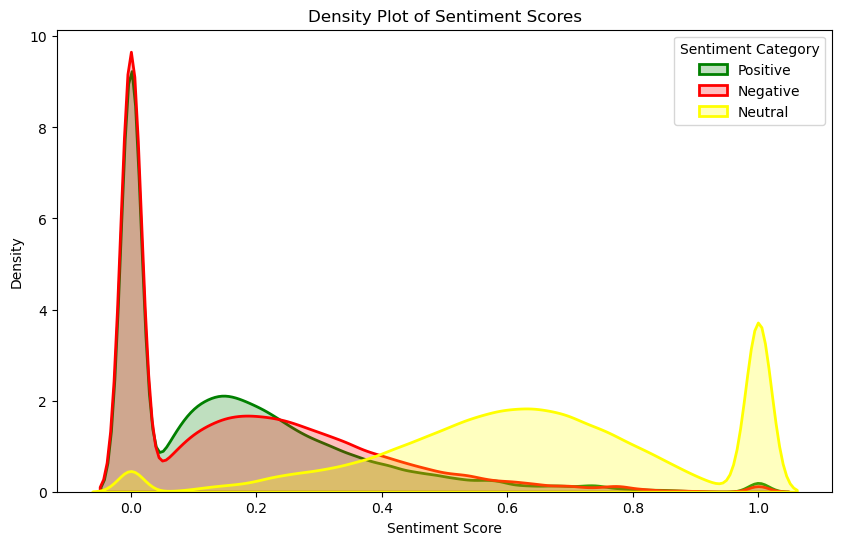

In [29]:
# Define the sentiment categories and corresponding colors
sentiment_categories = ["Positive", "Negative", "Neutral"]
colors = ['green', 'red', 'yellow']

# Set up the plot
plt.figure(figsize=(10, 6))

# Iterate over sentiment categories and plot KDE
for category, color in zip(sentiment_categories, colors):
    sns.distplot(new_df[category], hist=False, kde=True,
                 bins=int(180/5), color=color,
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'shade': True, 'linewidth': 2}, label=category)

# Set plot labels and legend
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Scores')
plt.legend(title='Sentiment Category')

# Show the plot
plt.show()


### Visualization of the Sentiment Scores

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_1641/4154235237.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/seaborn/distributions.py:2496: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




<Axes: xlabel='Compound', ylabel='Density'>

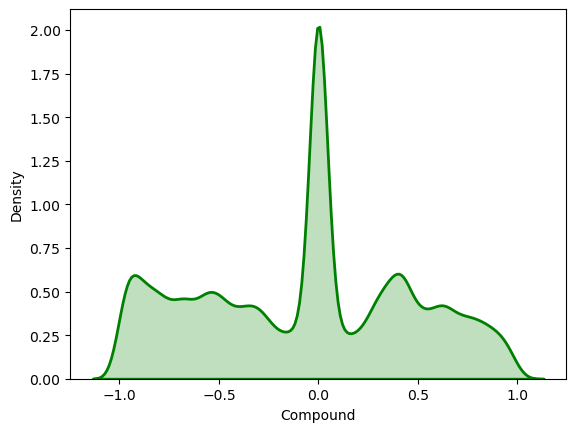

In [30]:
sns.distplot(new_df["Compound"], hist=False, kde=True,
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

### WordCloud of All Sentiments

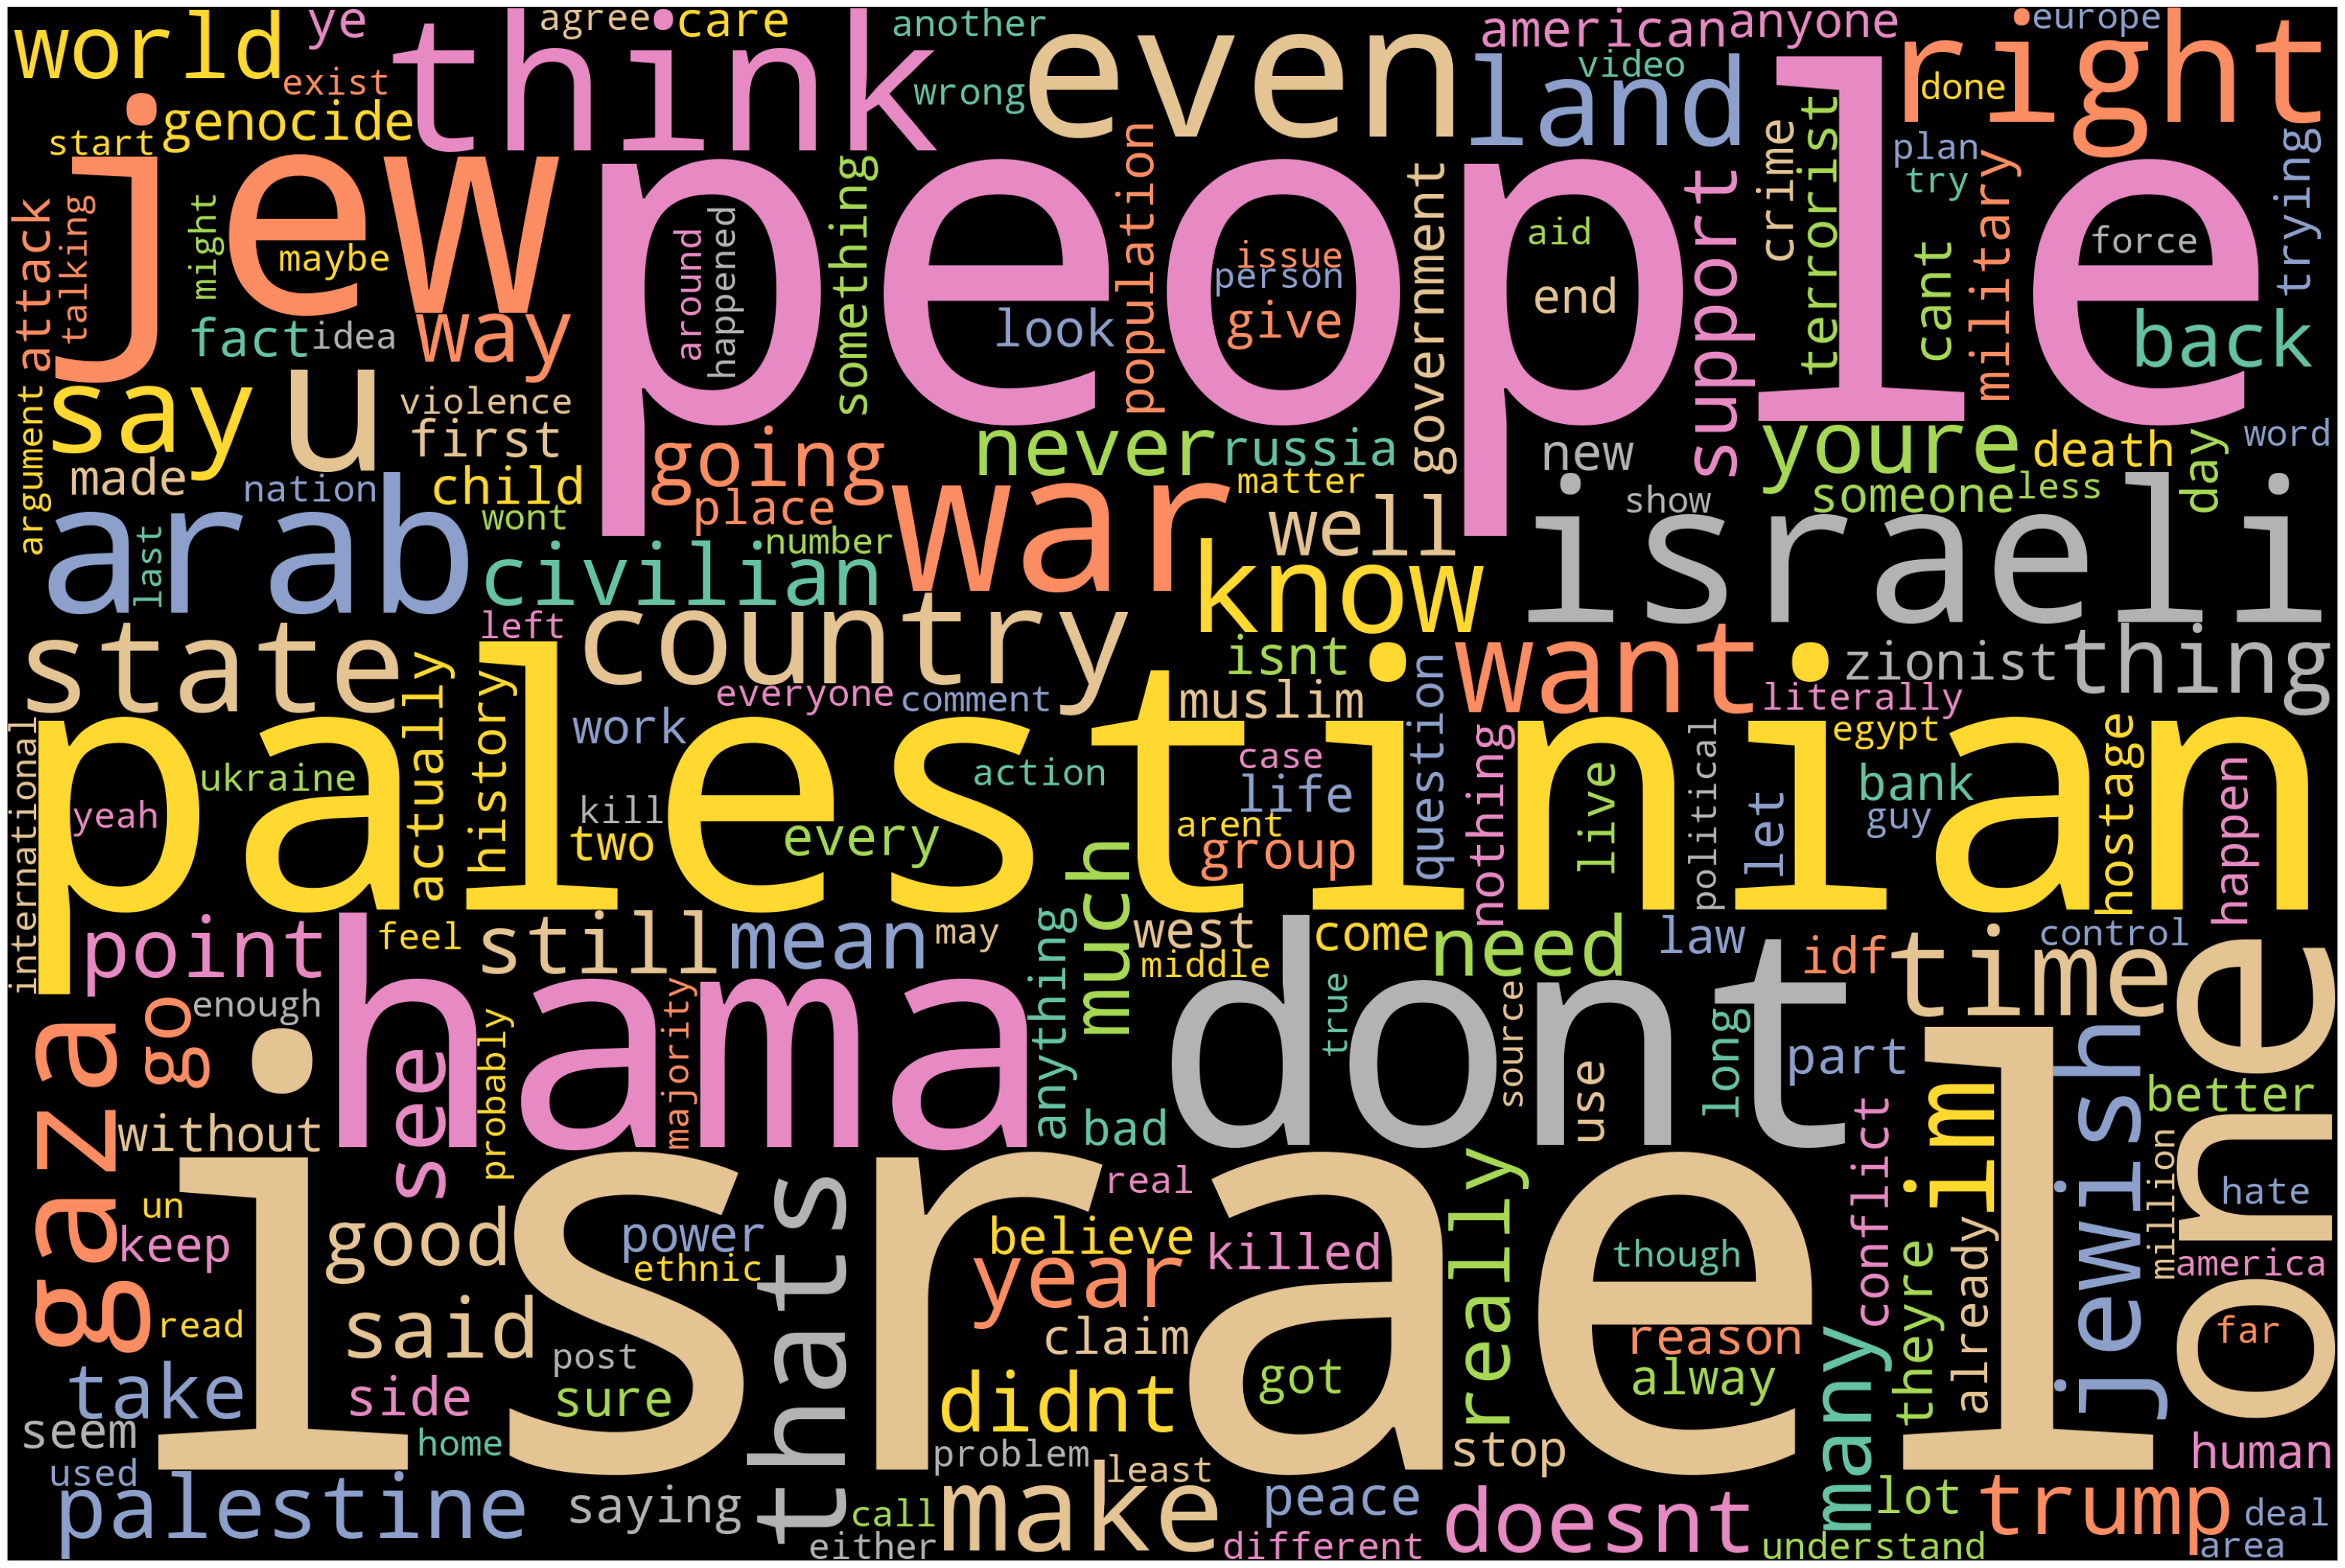

In [31]:
# Concatenate all comments into a single string
text = " ".join(comment for comment in new_df.clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(40, 30))

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


### WordCloud of Positive Sentiments

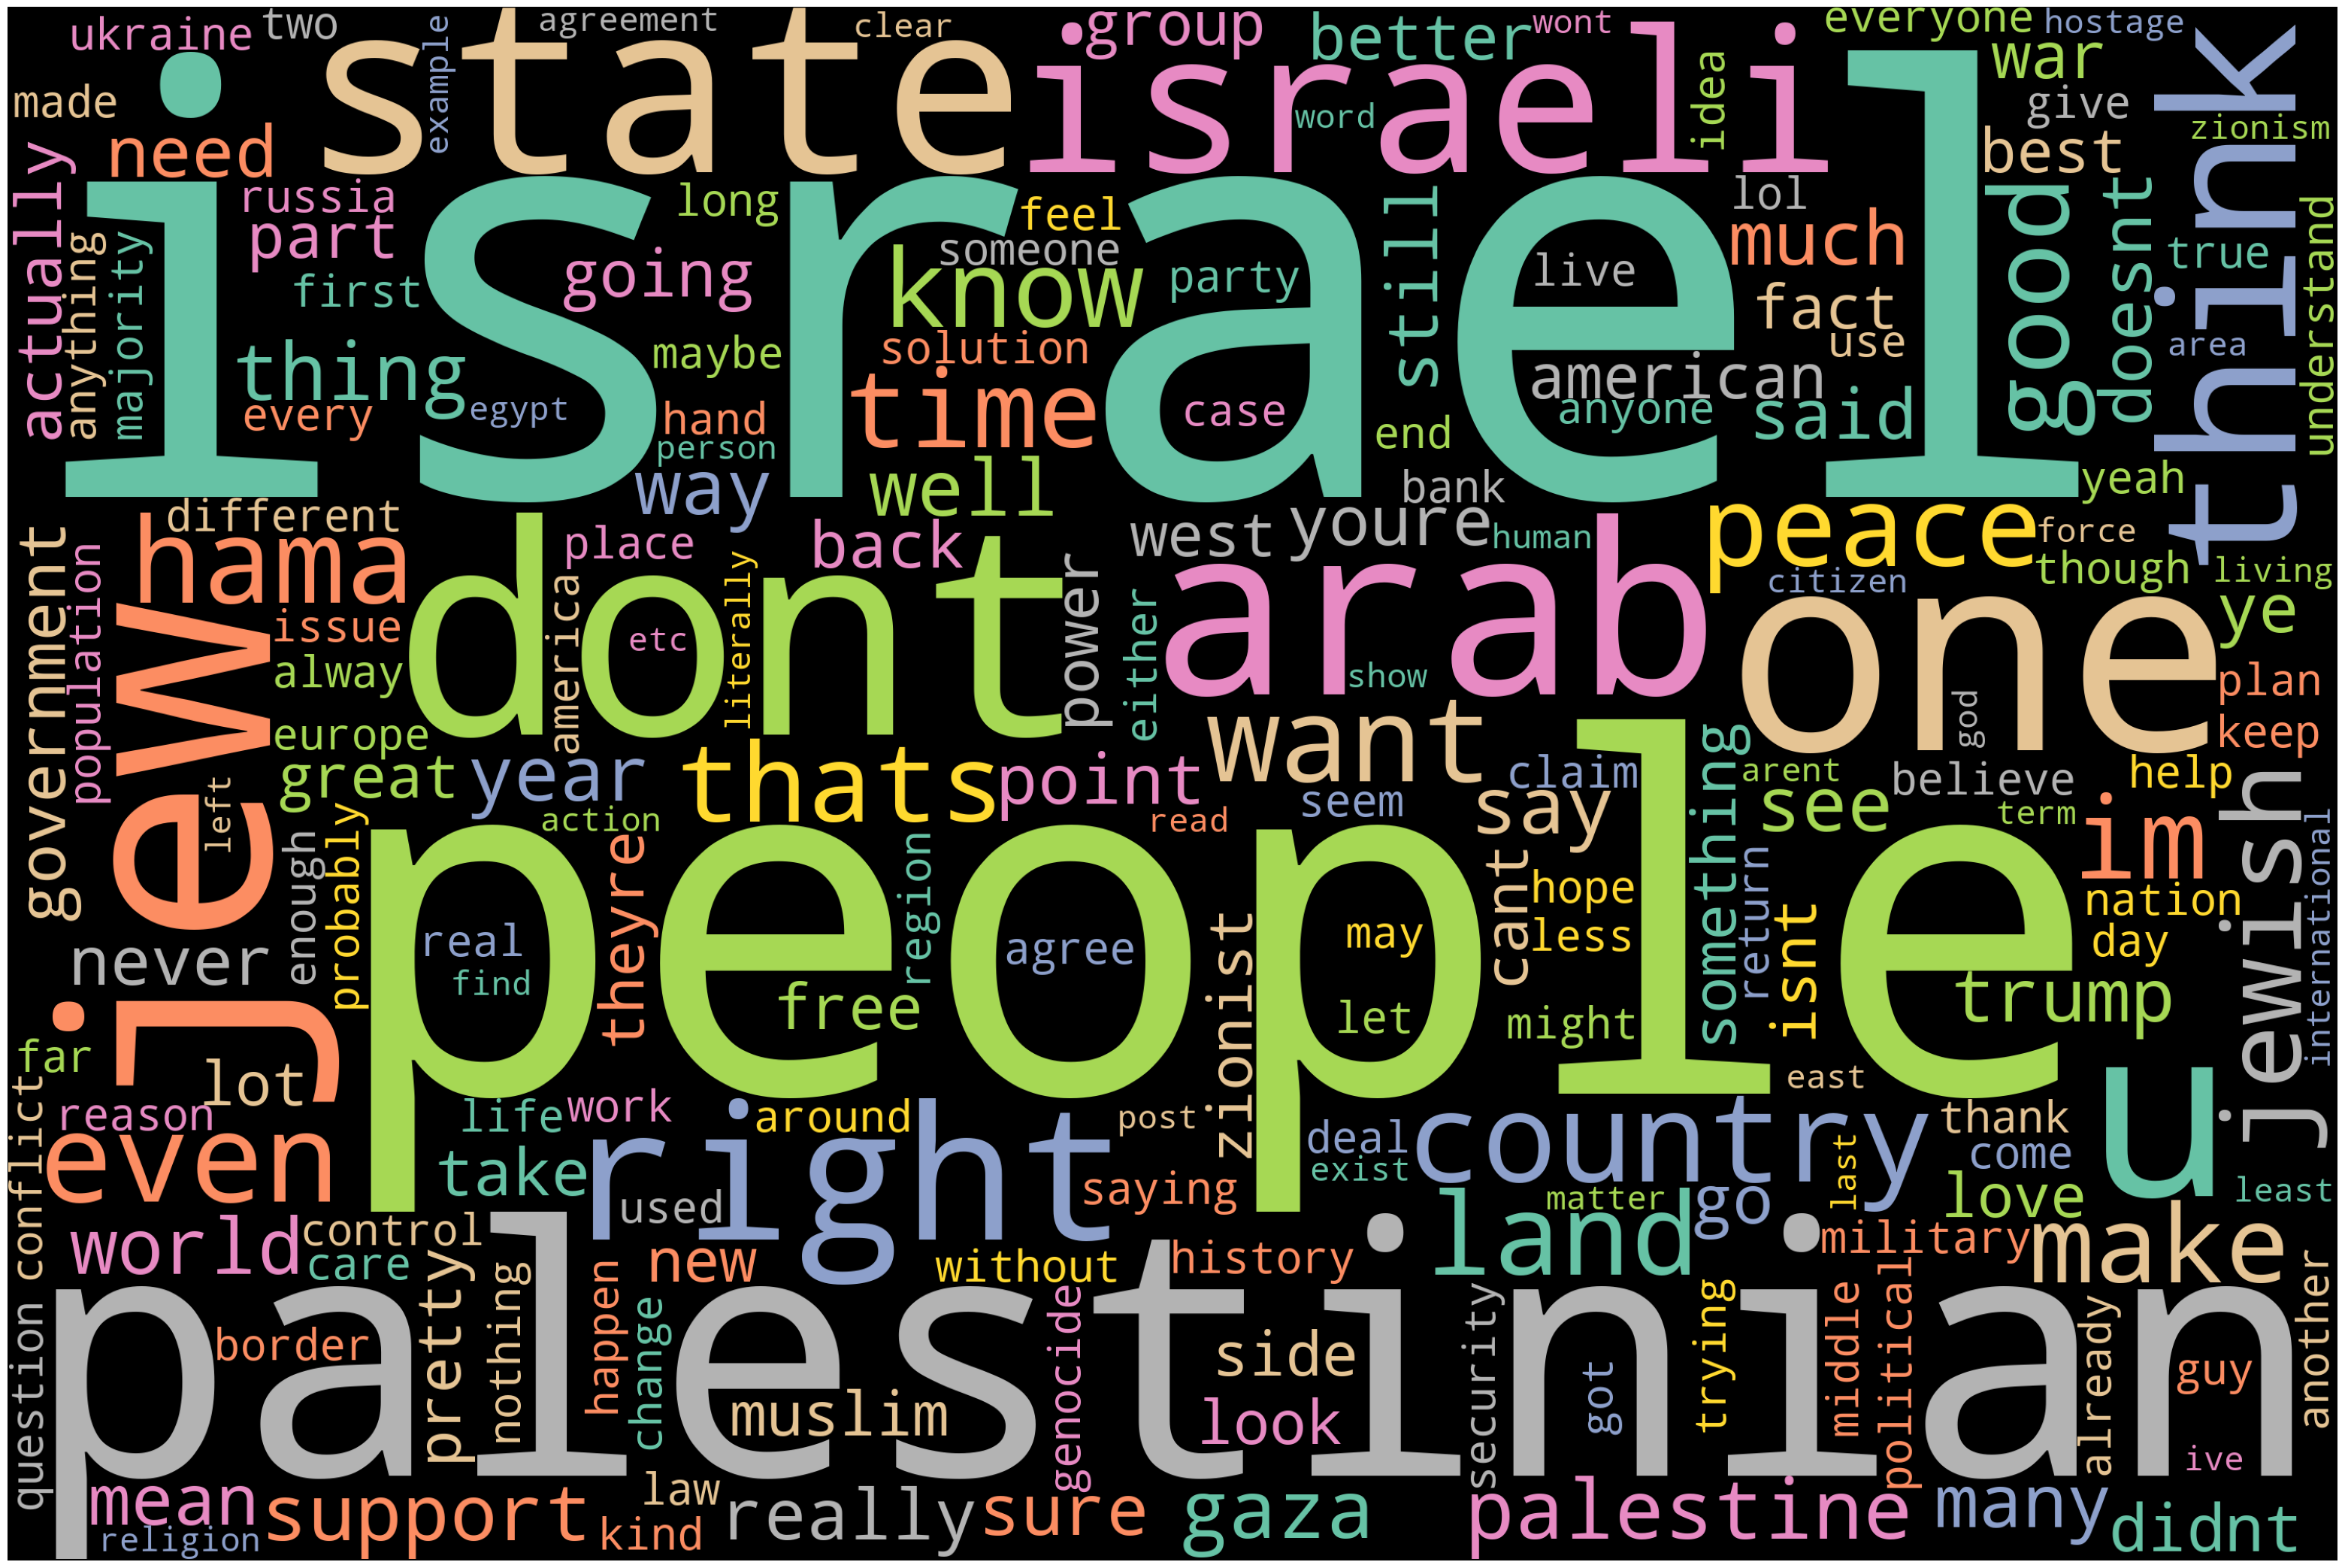

In [32]:
# Concatenate all comments into a single string
text = " ".join(comment for comment in new_df[new_df['Category']=='Positive'].clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(40, 30))

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


### WordCloud of Neutral Sentiments

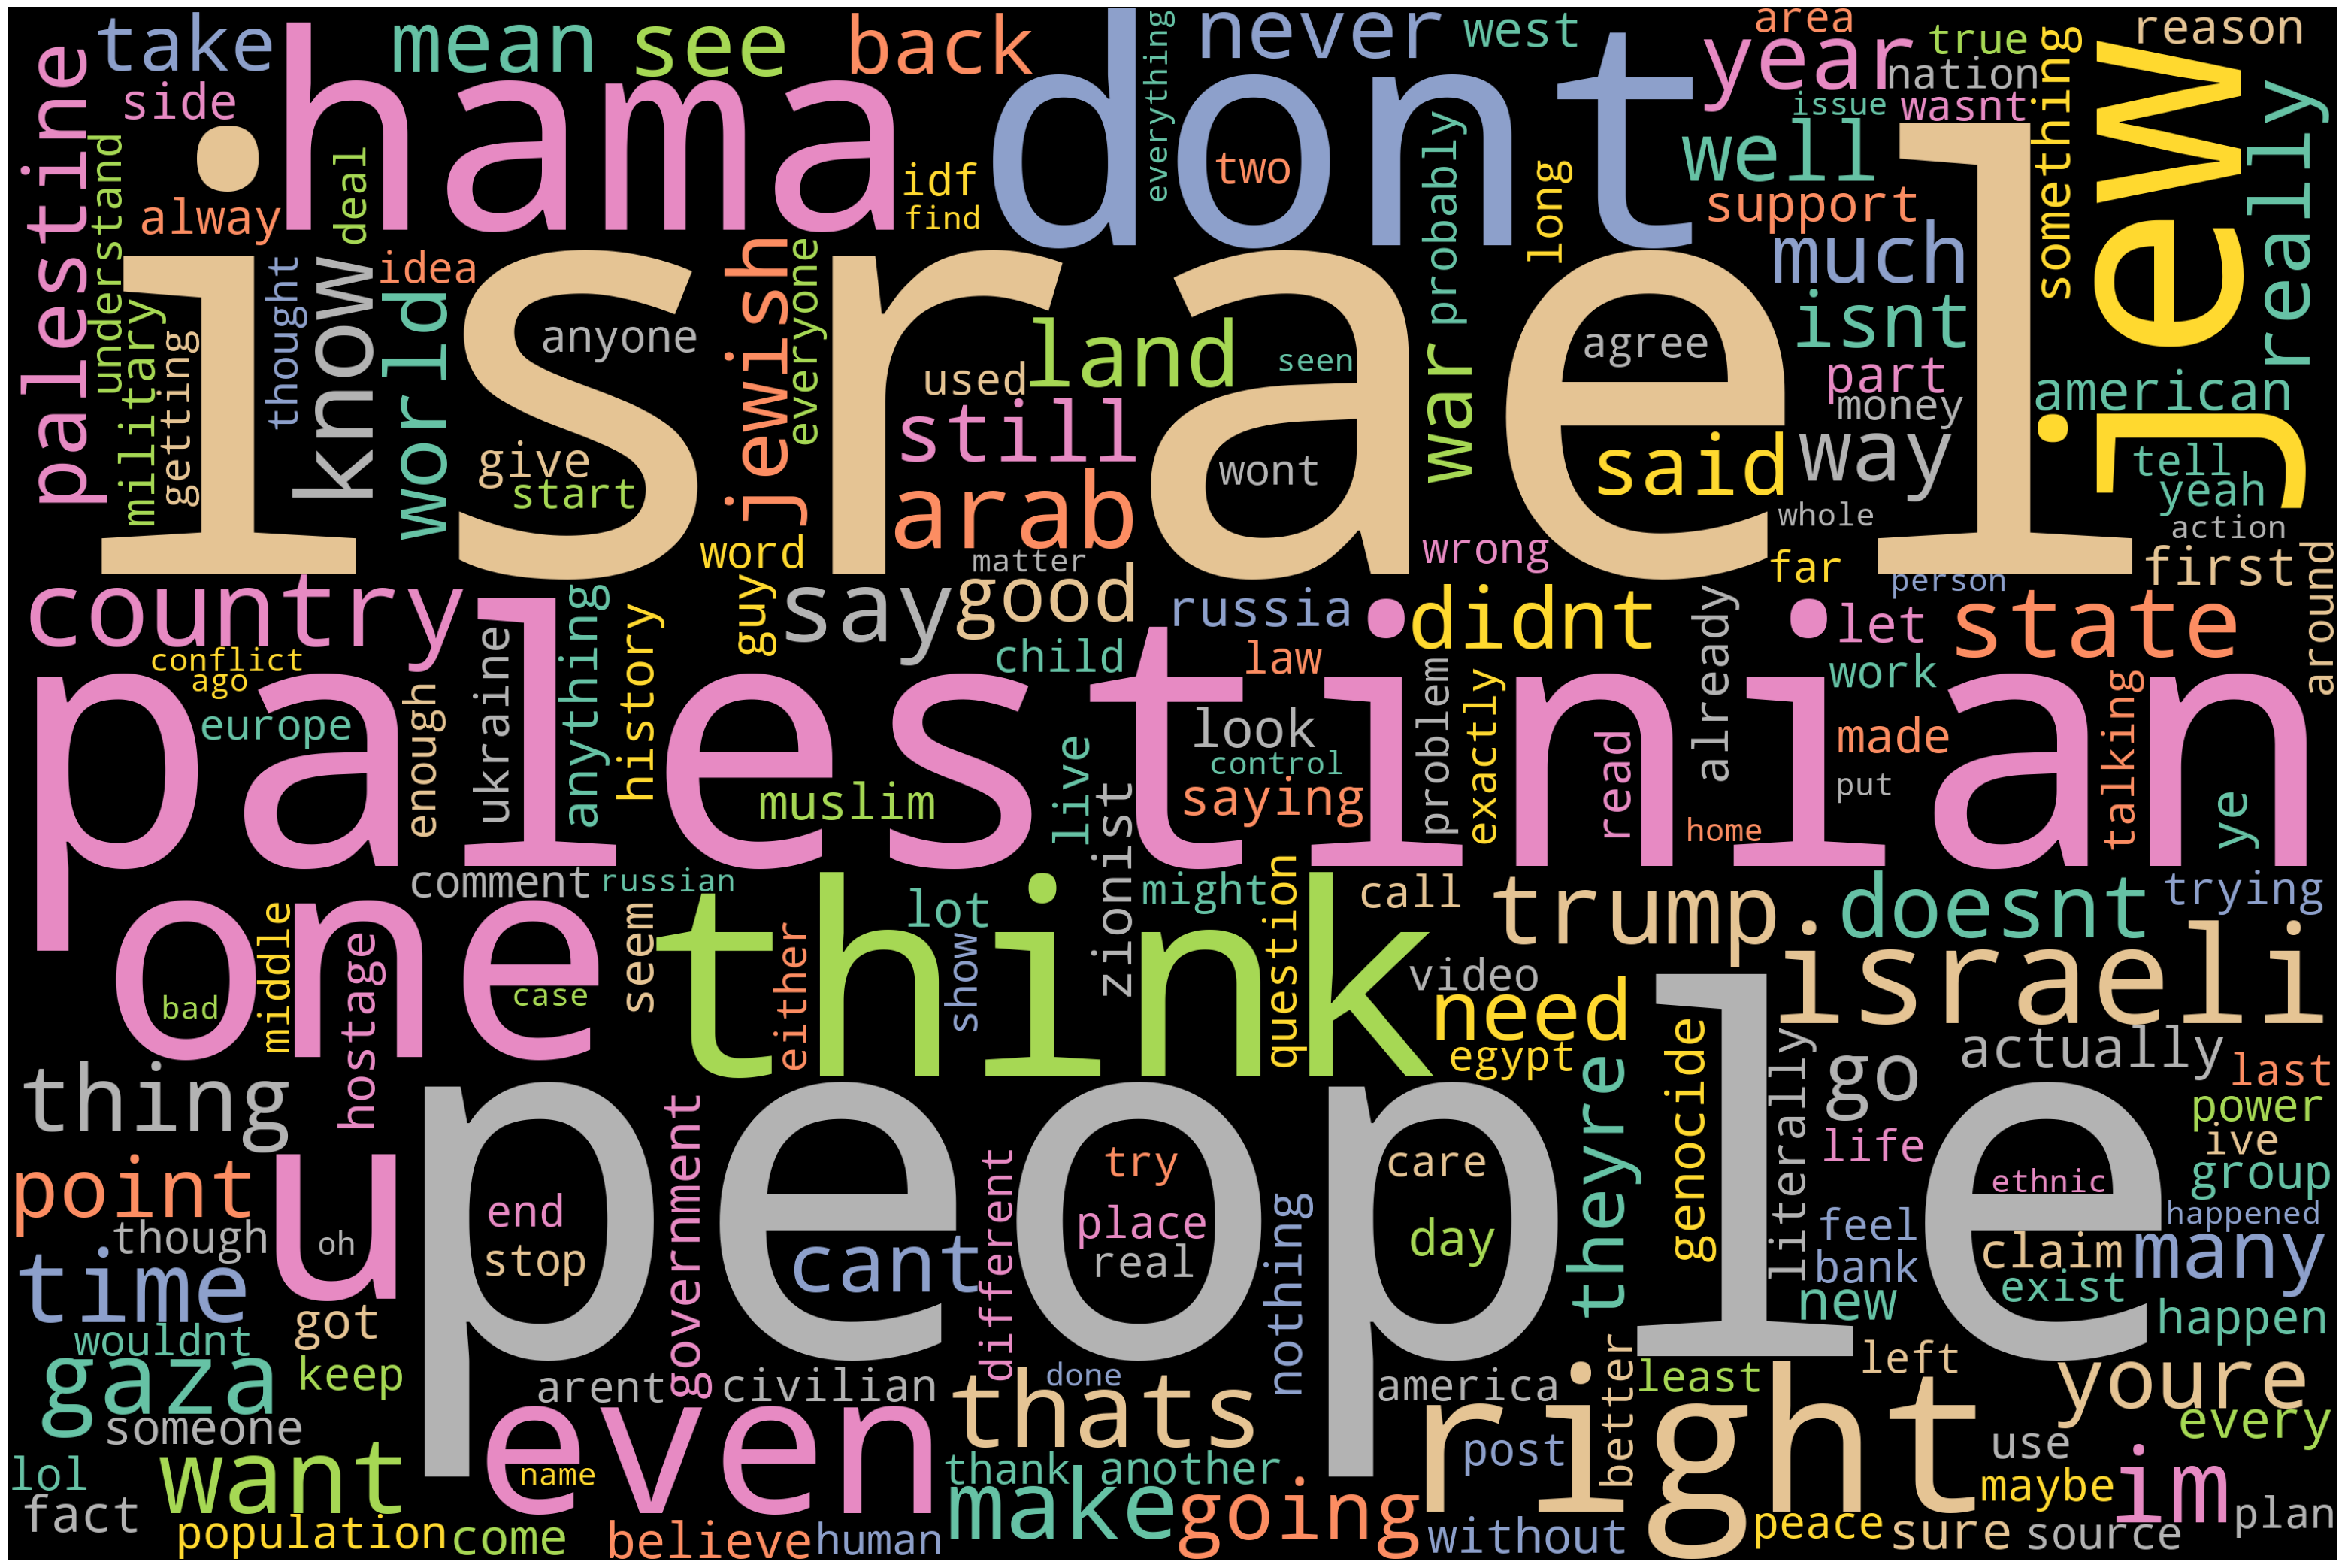

In [33]:
# Concatenate all comments into a single string
text = " ".join(comment for comment in new_df[new_df['Category']=='Neutral'].clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(40, 30))

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


### WordCloud of Negative Sentiments

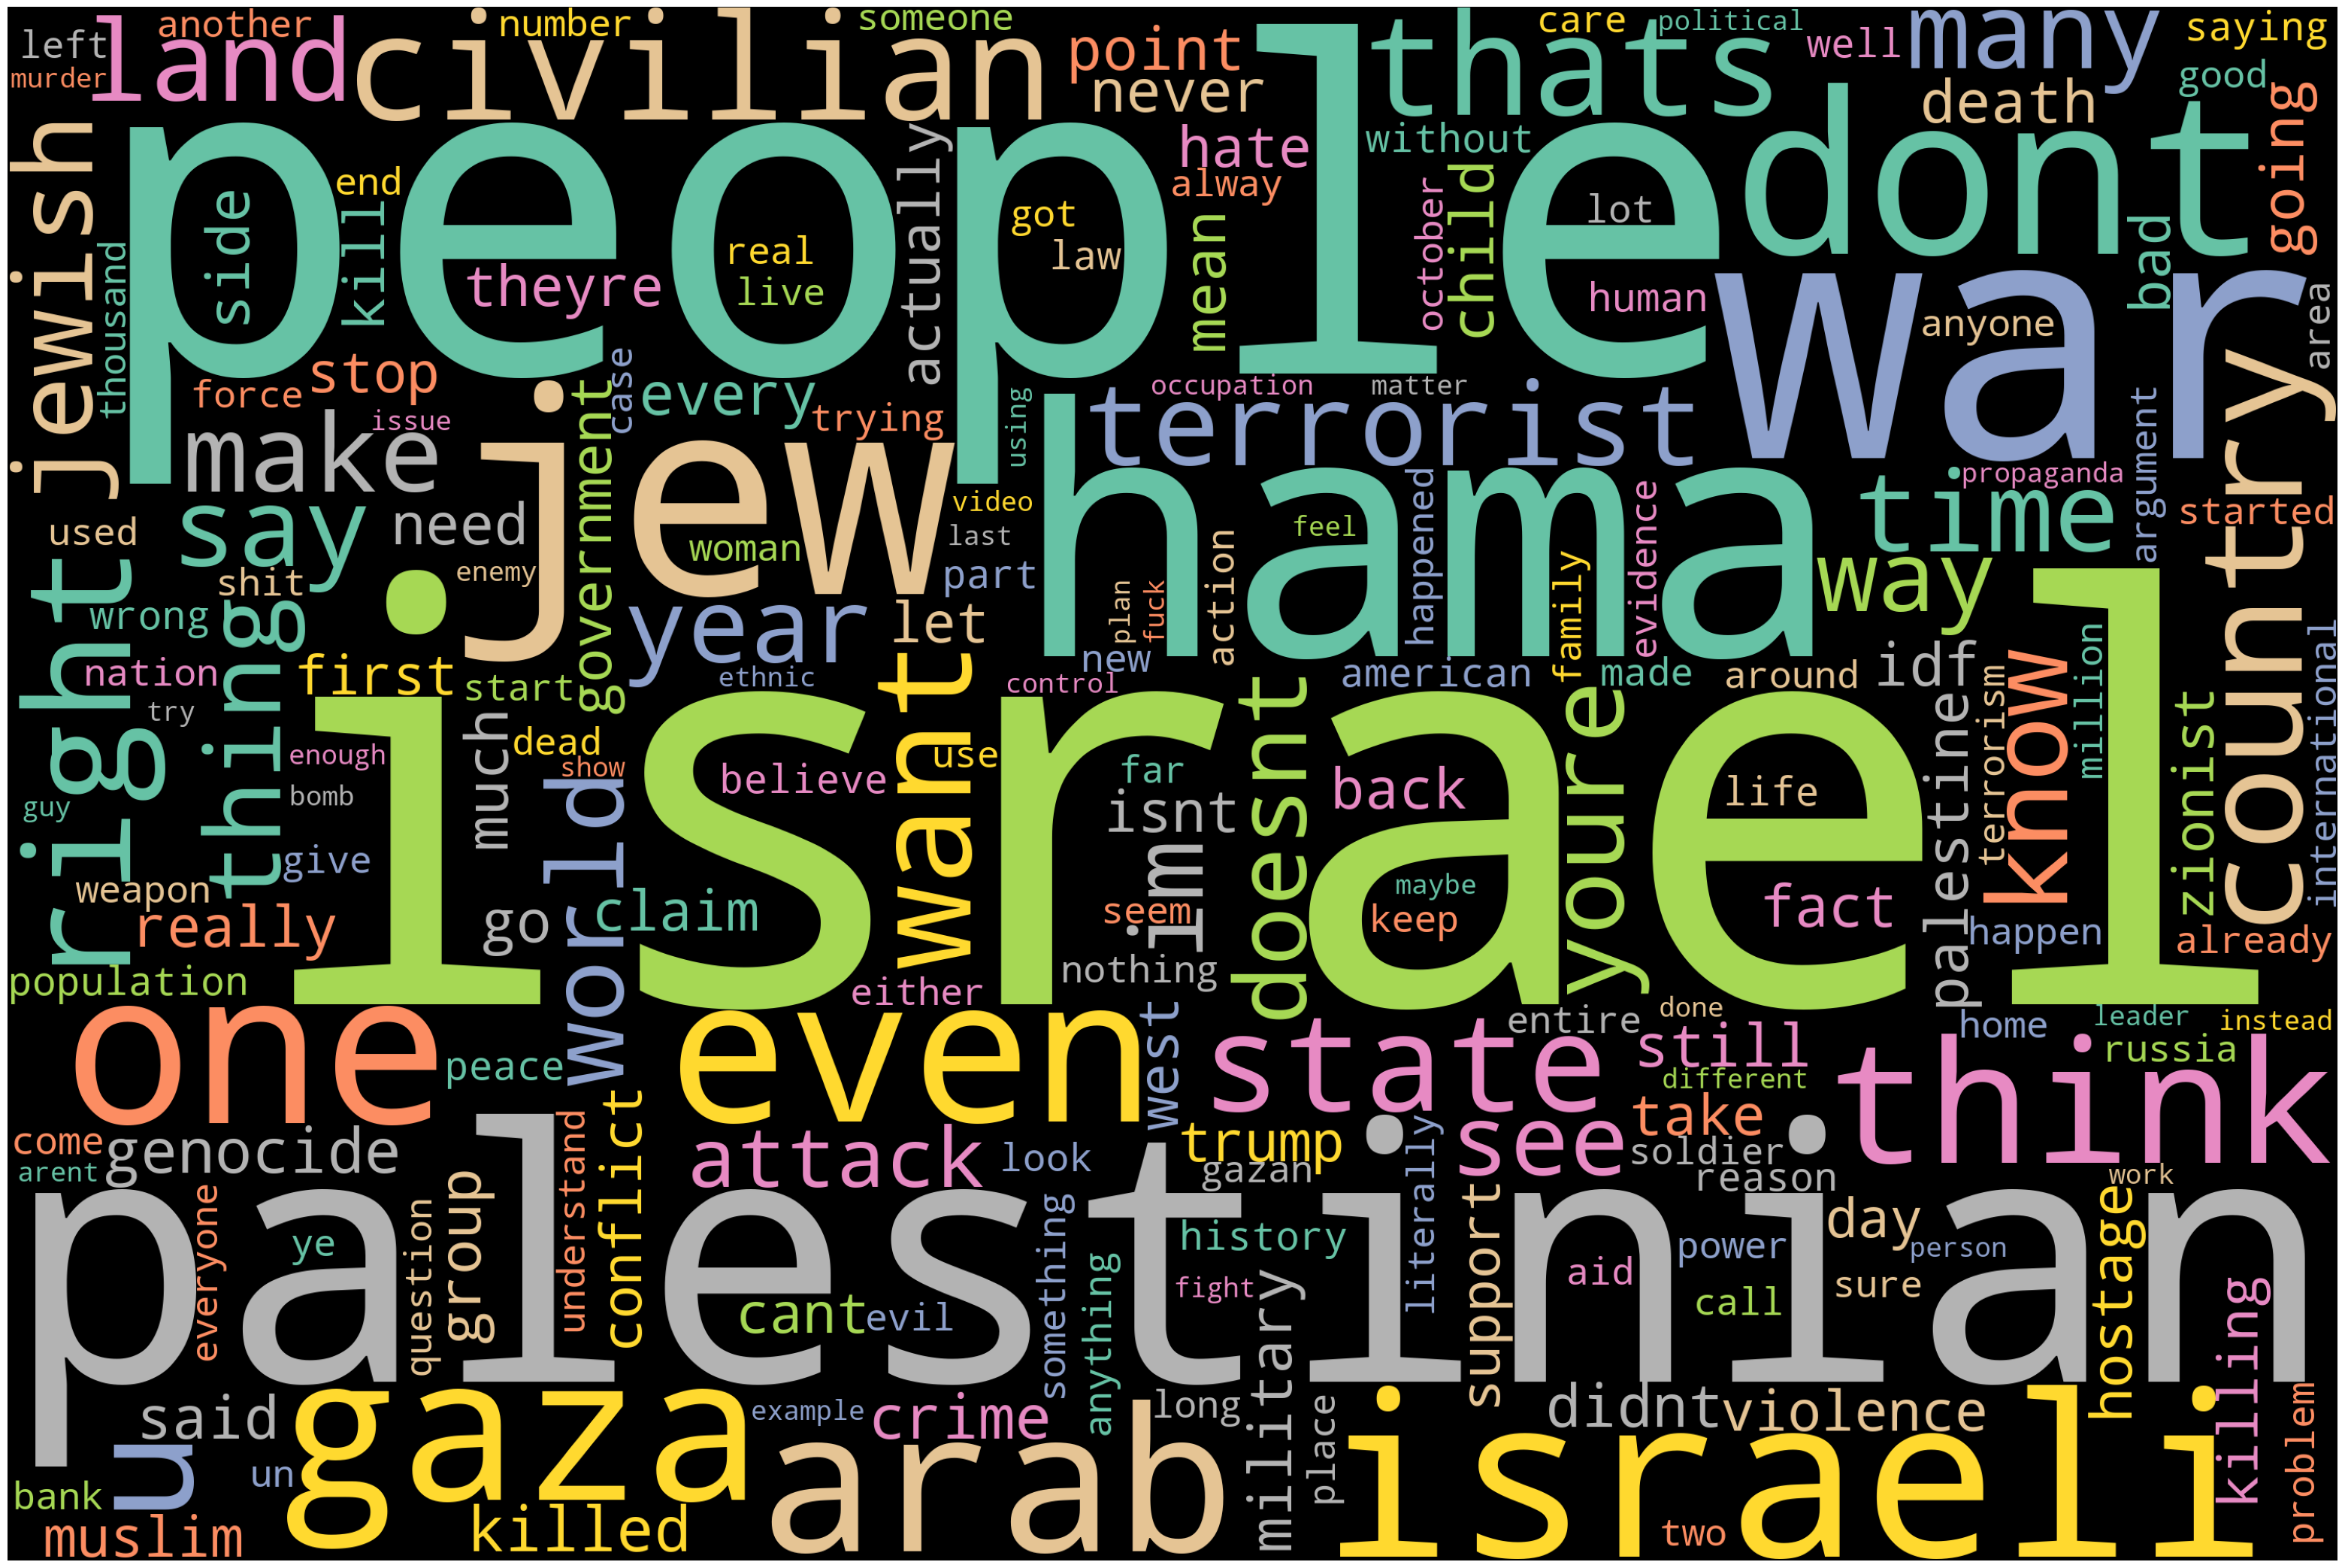

In [34]:
# Concatenate all comments into a single string
text = " ".join(comment for comment in new_df[new_df['Category']=='Negative'].clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(40, 30))

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2587784 entries, 0 to 2587783
Data columns (total 24 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   comment_id                  object        
 1   score                       int64         
 2   self_text                   object        
 3   subreddit                   object        
 4   created_time                datetime64[ns]
 5   post_id                     object        
 6   author_name                 object        
 7   controversiality            int64         
 8   ups                         int64         
 9   downs                       int64         
 10  user_is_verified            bool          
 11  user_account_created_time   object        
 12  user_awardee_karma          float64       
 13  user_awarder_karma          float64       
 14  user_link_karma             float64       
 15  user_comment_karma          float64       
 16  user_total_karma  

In [36]:
df.head()

comment_id  score                                          self_text  \
0    morieza      1  You are gonna save your hate-word for subs (pr...   
1    mori2on      1  &gt;current inability to accept normalization ...   
2    morhwu8      1  What do you consider settler violence?\n\nBeca...   
3    morhway      1  Wonder if they use camouflage on the mines ? D...   
4    morhw2t      1                                     Thank Goodness   

         subreddit        created_time  post_id        author_name  \
0  IsraelPalestine 2025-04-24 10:16:54  1k66pgp          bubberoff   
1  IsraelPalestine 2025-04-24 10:13:46  1k6ip4j       Shachar2like   
2  IsraelPalestine 2025-04-24 10:12:17  1k6ip4j  ThinkInternet1115   
3    CombatFootage 2025-04-24 10:12:09  1k6av4q          Snakehand   
4        worldnews 2025-04-24 10:12:05  1k6ky9d        PraetorGold   

   controversiality  ups  downs  ...  user_link_karma user_comment_karma  \
0                 0    1      0  ...              5.0             5796.0   
1                 0    1      0  ...           2994.0            87235.0   
2                 0    1      0  ...             70.0             9153.0   
3                 0    1      0  ...           6549.0            25157.0   
4                 0    1      0  ...            577.0            44287.0   

   user_total_karma  post_score  \
0            5801.0          87   
1           90229.0           6   
2            9223.0           6   
3           31706.0         481   
4           44864.0         985   

                                      post_self_text  \
0  As an African, i’ve noticed a particular patte...   
1  One of the great tragedies of the history of t...   
2  One of the great tragedies of the history of t...   
3                               Published 23.04.2025   
4                                                NaN   

                                          post_title  post_upvote_ratio  \
0                     Tokenization of Ethiopian Jews               0.87   
1  Is there a way to effectively resist settler v...               0.65   
2  Is there a way to effectively resist settler v...               0.65   
3  Russian armored vehicles were blown up by mine...               0.99   
4  Anti-Hamas protests on rise in Gaza as group's...               0.92   

   post_thumbs_ups post_total_awards_received    post_created_time  
0               87                          0  2025-04-23 18:35:35  
1                6                          0  2025-04-24 03:37:44  
2                6                          0  2025-04-24 03:37:44  
3              481                          0  2025-04-23 21:24:56  
4              985                          0  2025-04-24 05:53:58  

[5 rows x 24 columns]

# Positive or Negative Bias Detection

In [37]:
# Calculate the average sentiment scores for each subreddit
subreddit_sentiment = new_df.groupby('subreddit')[['Positive', 'Negative']].mean()

# Calculate the difference between positive and negative sentiment scores
subreddit_sentiment['Bias'] = subreddit_sentiment['Positive'] - subreddit_sentiment['Negative']

# Determine the direction of bias: Positive, Negative, or Neutral
def determine_bias_direction(bias):
    if bias > 0.01:  # You can adjust this threshold based on your dataset
        return 'Positive'
    elif bias < -0.01:  # You can adjust this threshold based on your dataset
        return 'Negative'
    else:
        return 'Neutral'

subreddit_sentiment['Bias Direction'] = subreddit_sentiment['Bias'].apply(determine_bias_direction)

# Sort subreddits based on bias in descending order
most_biased_subreddits = subreddit_sentiment.sort_values(by='Bias', ascending=False)

# Print or view the most biased subreddits with bias direction
print(most_biased_subreddits)


                       Positive  Negative      Bias Bias Direction
subreddit                                                         
NonCredibleDefense     0.161059  0.128831  0.032228       Positive
AskMiddleEast          0.172652  0.158621  0.014031       Positive
ActualPublicFreakouts  0.178071  0.164740  0.013331       Positive
CombatFootage          0.170573  0.162012  0.008561        Neutral
Palestine              0.183346  0.176240  0.007106        Neutral
AbruptChaos            0.155077  0.151087  0.003991        Neutral
CrazyFuckingVideos     0.159840  0.160357 -0.000517        Neutral
worldnews              0.166509  0.168443 -0.001934        Neutral
TerrifyingAsFuck       0.152918  0.167452 -0.014534       Negative
PublicFreakout         0.165219  0.182698 -0.017478       Negative
IsrealPalestineWar_23  0.182955  0.202364 -0.019409       Negative
IsraelPalestine        0.158469  0.180494 -0.022025       Negative
worldnewsvideo         0.161867  0.195590 -0.033723       Nega

In [38]:
# Step 3: Topic Modeling
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(new_df['clean_text'])
lda_model = LatentDirichletAllocation(n_components=5, random_state=42, n_jobs=-1)  # Assuming 5 topics
lda_topic_matrix = lda_model.fit_transform(tfidf_matrix)

# Topic Modelling

In [39]:
# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the top words for each topic
n_top_words = 10  # You can adjust this number to display more or fewer words per topic
top_words_per_topic = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_words_per_topic.append(top_words)

# Print the topics and associated words
for topic_idx, top_words in enumerate(top_words_per_topic):
    print(f"Topic #{topic_idx + 1}:")
    print(", ".join(top_words))
    print()


Topic #1:
like, thats, thank, comment, im, read, thanks, post, video, think

Topic #2:
trump, russia, ukraine, like, american, need, putin, dont, going, america

Topic #3:
israel, hamas, palestinian, war, gaza, israeli, people, hostage, terrorist, want

Topic #4:
child, hamas, people, dont, lol, like, know, fuck, good, source

Topic #5:
jew, arab, people, israel, palestinian, jewish, land, palestine, right, dont



In [40]:
# Get the vocabulary indices for 'israel' and 'palestine' in your vectorizer
israel_word_index = vectorizer.vocabulary_['israel']
palestine_word_index = vectorizer.vocabulary_['palestine']

In [41]:
topic_term_distribution = lda_model.components_

In [42]:
israel_topic_index = topic_term_distribution[:, israel_word_index].argmax()
palestine_topic_index = topic_term_distribution[:, palestine_word_index].argmax()

# Geopolitical Stance Determination Using Dominant Topics and Sentiment Scores

In [43]:
print(len(new_df))  # Should match the number of rows in 'Compound'
print(len(df))      # Should match the number of rows you're assigning to


241735
2587784


In [44]:
# Vectorize clean text in new_df only
X = vectorizer.transform(new_df['clean_text'])

# LDA topic distributions
topic_distributions = lda_model.transform(X)

# Dominant topics
dominant_topics = topic_distributions.argmax(axis=1)

# Classify stance
def classify_stance(score, topic):
    if score <= -0.5:
        return 'Against Israel/Palestine'
    elif score >= 0.5 and topic == israel_topic_index:
        return 'Supports Israel'
    elif score >= 0.5 and topic == palestine_topic_index:
        return 'Supports Palestine'
    else:
        return 'Neutral/Stance Not Clear'

# Assign to new_df only
new_df['geopolitical_stance'] = [
    classify_stance(score, topic)
    for score, topic in zip(new_df['Compound'], dominant_topics)
]


In [45]:
stance_counts = new_df['geopolitical_stance'].value_counts()
print("Geopolitical Stance Distribution:")
print(stance_counts)

Geopolitical Stance Distribution:
geopolitical_stance
Neutral/Stance Not Clear    160322
Against Israel/Palestine     62890
Supports Palestine            9747
Supports Israel               8776
Name: count, dtype: int64


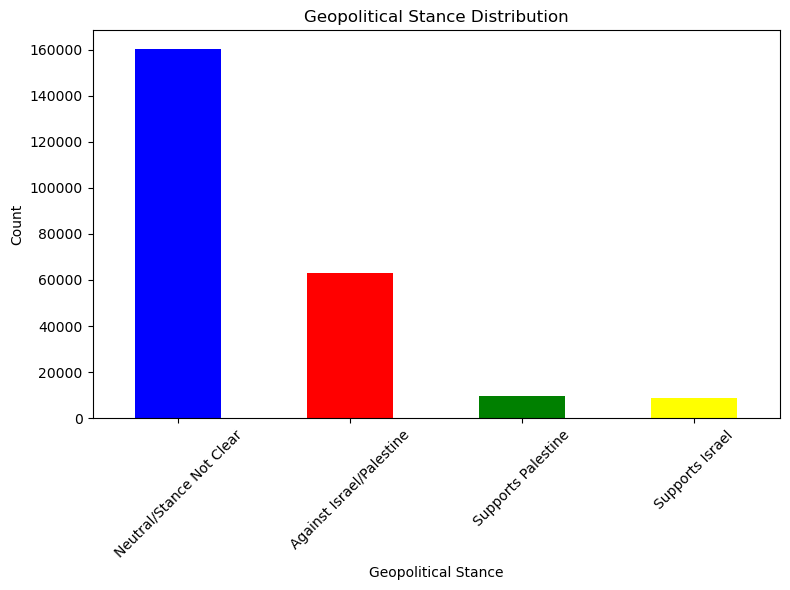

In [46]:
# Assuming 'geopolitical_stance' is a column in your DataFrame df
stance_counts = new_df['geopolitical_stance'].value_counts()

# Create bar chart using DataFrame values
plt.figure(figsize=(8, 6))
stance_counts.plot(kind='bar', color=['blue', 'red', 'green', 'yellow'])
plt.xlabel('Geopolitical Stance')
plt.ylabel('Count')
plt.title('Geopolitical Stance Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the chart
plt.show()

In [47]:
new_df.head()

comment_id  score                                          self_text  \
0    morieza      1  You are gonna save your hate-word for subs (pr...   
1    mori2on      1  &gt;current inability to accept normalization ...   
2    morhwu8      1  What do you consider settler violence?\n\nBeca...   
3    morhway      1  Wonder if they use camouflage on the mines ? D...   
4    morhw2t      1                                     Thank Goodness   

         subreddit        created_time  post_id        author_name  \
0  IsraelPalestine 2025-04-24 10:16:54  1k66pgp          bubberoff   
1  IsraelPalestine 2025-04-24 10:13:46  1k6ip4j       Shachar2like   
2  IsraelPalestine 2025-04-24 10:12:17  1k6ip4j  ThinkInternet1115   
3    CombatFootage 2025-04-24 10:12:09  1k6av4q          Snakehand   
4        worldnews 2025-04-24 10:12:05  1k6ky9d        PraetorGold   

   controversiality  ups  downs  ...  post_thumbs_ups  \
0                 0    1      0  ...               87   
1                 0    1      0  ...                6   
2                 0    1      0  ...                6   
3                 0    1      0  ...              481   
4                 0    1      0  ...              985   

  post_total_awards_received    post_created_time  \
0                          0  2025-04-23 18:35:35   
1                          0  2025-04-24 03:37:44   
2                          0  2025-04-24 03:37:44   
3                          0  2025-04-23 21:24:56   
4                          0  2025-04-24 05:53:58   

                                          clean_text  Compound  Positive  \
0  gon na save hateword sub presumably hateful ap...    0.9169     0.416   
1  current inability accept normalization palesti...   -0.2023     0.153   
2  consider settler violence lot palestinian cons...   -0.9712     0.135   
3  wonder use camouflage mine driving buried mine...    0.0000     0.000   
4                                     thank goodness    0.6705     1.000   

   Negative  Neutral  Category       geopolitical_stance  
0     0.128    0.455  Positive  Neutral/Stance Not Clear  
1     0.259    0.588   Neutral  Neutral/Stance Not Clear  
2     0.348    0.517  Negative  Against Israel/Palestine  
3     0.000    1.000   Neutral  Neutral/Stance Not Clear  
4     0.000    0.000  Positive  Neutral/Stance Not Clear  

[5 rows x 31 columns]

### Geopolitical Stance Distribution (2023):

- **Neutral/Stance Not Clear:** The majority of the data falls into this category with a count of 286,000. This suggests that a significant portion of the dataset does not express a clear geopolitical stance on the Israel-Palestine issue.

- **Against Israel/Palestine:** There are 62,890 instances where the stance is against Israel/Palestine. This indicates a substantial portion of the data expressing a negative sentiment or opposition towards Israel, Palestine, or both.

- **Supports Palestine:** There are 13,911 instances where the stance supports Palestine. This represents a smaller but notable segment of the data that expresses support for the Palestinian side of the conflict.

- **Supports Israel:** There are 13,722 instances where the stance supports Israel. Similar to supporting Palestine, supporting Israel is also expressed by a smaller but significant portion of the dataset.

In summary, the majority of the data does not express a clear stance. Among those that do, there is a considerable diversity of opinions, with a slightly higher number of instances leaning against Israel/Palestine.


### Geopolitical Stance Distribution (2025):

- **Neutral/Stance Not Clear:** The majority of the data falls into this category with a count of 168,065. This suggests that a significant portion of the dataset does not express a clear geopolitical stance on the Israel-Palestine issue.

- **Against Israel/Palestine:** There are 123,092 instances where the stance is against Israel/Palestine. This indicates a substantial portion of the data expressing a negative sentiment or opposition towards Israel, Palestine, or both.

- **Supports Palestine:** There are 13,911 instances where the stance supports Palestine. This represents a smaller but notable segment of the data that expresses support for the Palestinian side of the conflict.

- **Supports Israel:** There are 10,780 instances where the stance supports Israel. Similar to supporting Palestine, supporting Israel is also expressed by a smaller but significant portion of the dataset.


In 2025, there are far more instances where the stance is against Israel/Palestine. In 2023, around the same number of instances support Israel and support Palestine (~13/14 thousand). In 2025, there is a higher proportion of support for Palestine (~14,000 vs ~11,000 supporting Israel).

Next, I wanted to fit a multiple linear regression to see what factors (Political stance, positive/negative/neutral, time(?))

In [48]:
len(new_df)
new_df.tail()

comment_id  score                                          self_text  \
241730    m85kq5p     -2  Biden is strength. Trump is a paper tiger, a w...   
241731    m85kknh     17                  Friend? More like sugar daddy imo   
241732    m85ki38     49  The Houthis' [flag and slogan](https://en.wiki...   
241733    m85kdy8    -57  Lol.\n\nI hate Trump - but he has his uses.\n\...   
241734    m85jsk5     15  This is a sideways step.. Houthis will only at...   

        subreddit        created_time  post_id           author_name  \
241730  worldnews 2025-01-20 13:10:37  1i5pln5    Kind-Afternoon8399   
241731  worldnews 2025-01-20 13:09:32  1i5pln5             -TheWill-   
241732  worldnews 2025-01-20 13:09:02  1i5pln5         if_it_is_in_a   
241733  worldnews 2025-01-20 13:08:13  1i5pln5           SlyRax_1066   
241734  worldnews 2025-01-20 13:03:56  1i5pln5  Hefty-Relationship-8   

        controversiality  ups  downs  ...  post_thumbs_ups  \
241730                 1   -2      0  ...             5059   
241731                 0   17      0  ...             5059   
241732                 0   49      0  ...             5059   
241733                 0  -57      0  ...             5059   
241734                 0   15      0  ...             5059   

       post_total_awards_received    post_created_time  \
241730                          0  2025-01-20 12:59:15   
241731                          0  2025-01-20 12:59:15   
241732                          0  2025-01-20 12:59:15   
241733                          0  2025-01-20 12:59:15   
241734                          0  2025-01-20 12:59:15   

                                               clean_text  Compound  Positive  \
241730  biden strength trump paper tiger weak man vers...    0.0240     0.225   
241731                        friend like sugar daddy imo    0.6908     0.655   
241732  houthis flag slogan plastered everywhere truck...    0.4215     0.207   
241733  lol hate trump us one attack anything american...   -0.7783     0.144   
241734  sideways step houthis attack israel friend ira...   -0.2523     0.208   

        Negative  Neutral  Category       geopolitical_stance  
241730     0.222    0.553   Neutral  Neutral/Stance Not Clear  
241731     0.000    0.345  Positive  Neutral/Stance Not Clear  
241732     0.091    0.702   Neutral  Neutral/Stance Not Clear  
241733     0.495    0.361  Negative  Against Israel/Palestine  
241734     0.338    0.454   Neutral  Neutral/Stance Not Clear  

[5 rows x 31 columns]

In [ ]:
import statsmodels.api as sm


# Inferences

### **Why Neutral or Unclear Stance is Disturbing:**

1. **Humanitarian Crisis:** The war has led to a significant humanitarian crisis, with a large number of civilian casualties, including children. A neutral stance might indicate a lack of active engagement for a peaceful resolution, potentially perpetuating the crisis.

2. **Potential for Change:** A neutral stance might imply a failure to actively work towards a resolution. With so many lives at stake, not actively supporting efforts for peace could be seen as a missed opportunity to make a positive impact.

3. **Moral Responsibility:** Some argue that in the face of significant human suffering, individuals and nations have a moral responsibility to take a stand against violence and advocate for peaceful solutions. A neutral stance might be perceived as shirking this responsibility.

4. **Perpetuation of War:** A lack of active engagement might inadvertently support the status quo, allowing the war to continue without significant international pressure for resolution. This can lead to more lives being lost and the prolongation of suffering.

5. **Missed Opportunities for Diplomacy:** International pressure and diplomacy can play a crucial role in war resolution. By not picking a side, opportunities for diplomatic efforts and negotiations might be missed, hindering the chances of finding a peaceful resolution.

6. **Failure to Address Root Causes:** Taking a neutral stance means avoiding addressing the underlying issues that fuel the war, such as territorial disputes and human rights violations. Without addressing these root causes, long-term peace and stability are impossible to achieve.

7. **Lack of Moral Clarity:** In situations with clear human rights violations, a neutral stance cab be seen as a lack of moral clarity and a failure to stand up against injustice.

In summary, a neutral or complacent stance in the Israel-Palestine war might be perceived as problematic because it can contribute to the continuation of the war and the suffering of those involved. Many advocate for active engagement, dialogue, and efforts toward a peaceful resolution to prevent further loss of lives, especially among vulnerable populations like children.
